### Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

### Data Loading

In [4]:
# dtypes for csv fields
dtypes = {
    'holiday':str,
    'temp':float,
    'rain_1h':float,
    'snow_1h':float,
    'clouds_all':int,
    'weather_main':str,
    'weather_description':str,
    'date_time':str,
    'traffic_volume':int
    }
# dates to be parsed from the csv
parse_dates = ['date_time']

# read csv
data = pd.read_csv("../data/Metro_Interstate_Traffic_Volume.csv", dtype=dtypes, parse_dates=parse_dates)
data['date_time'] = pd.to_datetime(data['date_time'])
# drop unwanted columns
unwanted_cols = ['weather_description'] 
data = data.drop(unwanted_cols, axis=1)
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,2012-10-02 13:00:00,4918


### Data Viz

#### Distribuição das condições meterológicas

{'Clouds': 15164, 'Clear': 13391, 'Rain': 5672, 'Drizzle': 1821, 'Mist': 5950, 'Haze': 1360, 'Fog': 912, 'Thunderstorm': 1034, 'Snow': 2876, 'Squall': 4, 'Smoke': 20}


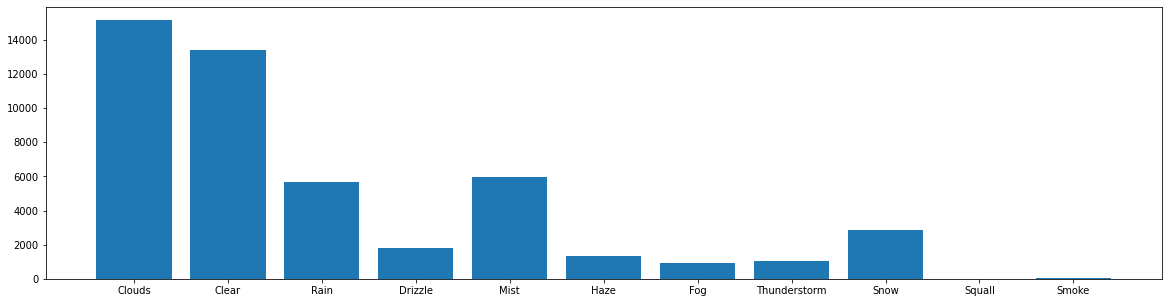

In [5]:
weather = data.weather_main
weatherStr = {'Clouds':0, 'Clear':0, 'Rain':0, 'Drizzle':0, 'Mist':0, 'Haze':0, 'Fog':0, 'Thunderstorm':0, 'Snow':0, 'Squall':0, 'Smoke':0}
for x in list(weather):
    weatherStr[x] += 1

print(weatherStr)
plt.figure(figsize=(20,5))
plt.bar(weatherStr.keys(), weatherStr.values())
plt.show()

#### Distri por hora

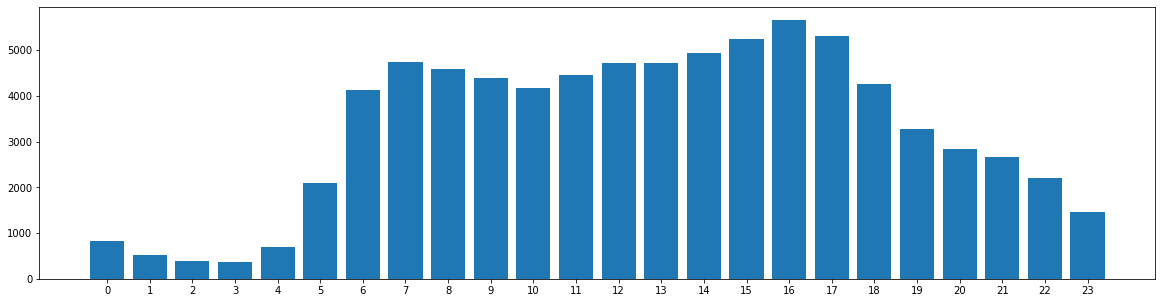

In [6]:
# Conta aparições de cada hora (para cobrir o caso de haverem gaps nos dados)
horaCount = [0]*24
# dict, vai contem soma de passageiros em cada hora
hora = {}
for x in range(24):
    hora[x]=0

for x in range(24):
    dados = data.loc[data['date_time'].dt.hour == x]
    soma = 0
    for i in dados.traffic_volume:
        soma = soma + i
        horaCount[x] += 1
    hora[x] = soma/horaCount[x]

plt.figure(figsize=(20,5))
plt.xticks(range(24))
plt.bar(hora.keys(), hora.values())
plt.show()

#### Distribuições

In [4]:
# Ver distribuição da temperatura, 0K é impossível
print("Dados de Temperatura: Min:{:.2f}K Max:{:.2f}K Média:{:.2f}K".format(data.temp.min(),data.temp.max(),data.temp.mean()))
# Quase 10 metros por hora no max, corrigir
print("Dados de Chuva: Min:{:.2f} mm/h Max:{:.2f} mm/h Média:{:.2f} mm/h".format(data.rain_1h.min(),data.rain_1h.max(),data.rain_1h.mean()))
print("Dados de Neve: Min:{:.2f} mm/h Max:{:.2f} mm/h Média:{:.2f} mm/h".format(data.snow_1h.min(),data.snow_1h.max(),data.snow_1h.mean()))

Dados de Temperatura: Min:0.00K Max:310.07K Média:281.21K
Dados de Chuva: Min:0.00 mm/h Max:9831.30 mm/h Média:0.33 mm/h
Dados de Neve: Min:0.00 mm/h Max:0.51 mm/h Média:0.00 mm/h


### Corrigir outliers

- Chuva

In [42]:
data.loc[data['rain_1h']>100] = data.rain_1h.mean()
print("Dados de Chuva: Min:{:.2f} mm/h Max:{:.2f} mm/h Média:{:.2f} mm/h".format(data.rain_1h.min(),data.rain_1h.max(),data.rain_1h.mean()))

Dados de Chuva: Min:0.00 mm/h Max:55.63 mm/h Média:0.13 mm/h


In [ ]:
data.loc[data['temp']<0] = data.temp.mean()

- Todos os dias

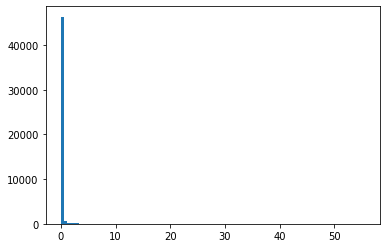

In [44]:
plt.hist(data.rain_1h, bins=100)
plt.show()

- Dias de chuva

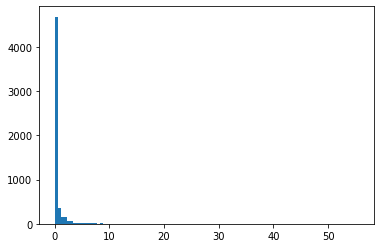

In [45]:
rainDays = data.loc[data['weather_main'] == 'Rain']
plt.hist(rainDays.rain_1h, bins=100)
plt.show()

- Dias de tempestade

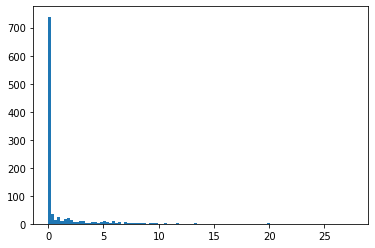

In [47]:
stormDays = data.loc[data['weather_main'] == 'Thunderstorm']
plt.hist(stormDays.rain_1h, bins=100)
plt.show()

- Dias de Neve

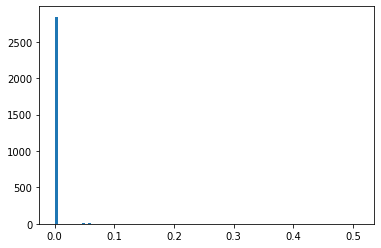

In [48]:
snowDays = data.loc[data['weather_main'] == 'Snow']
plt.hist(snowDays.snow_1h, bins=100)
plt.show()

- Nuvens

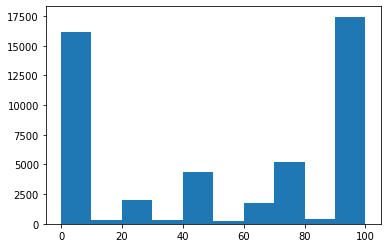

In [61]:
plt.hist(data.clouds_all, bins=10)
plt.show()

# Fields a utilizar
#### x:
- 'holiday':str,
- 'temp':float,
- 'weather_main':str,
- 'date_time':str

#### y:    
- 'traffic_volume':int

### Data Manipulation
- holiday -> 0/1
- weather -> One hot encoding/order(?)
- weekday vs weekend -> 0/1

In [57]:
unwanted_cols = ['rain_1h', 'snow_1h'] 
data = data.drop(unwanted_cols, axis=1)
data.head()

,holiday,temp,clouds_all,weather_main,date_time,traffic_volume
0,None,288.28,40,Clouds,2012-10-02 09:00:00,5545
1,None,289.36,75,Clouds,2012-10-02 10:00:00,4516
2,None,289.58,90,Clouds,2012-10-02 11:00:00,4767
3,None,290.13,90,Clouds,2012-10-02 12:00:00,5026
4,None,291.14,75,Clouds,2012-10-02 13:00:00,4918


### Univariative dataset

In [65]:
unwanted_cols = ['holiday', 'temp', 'clouds_all', 'weather_main'] 
uni_dataset = data
uni_dataset = uni_dataset.drop(unwanted_cols, axis=1)
uni_dataset.head()
uni_dataset.to_csv('univariative_data.csv', index=False)